# Robust Feature Importance Methodologies

Traditional models using white box models have several problems when it comes to feature importance interpretability. For instance, the strong assumption they have, inconsistency, etc. 

Thus, now, this notebook will show a more reliable approach using these methods below:

- Permutation Feature Importance
- Partial Dependence Plots (PDPs)
- Individual Conditional Expectation (ICE)
- An extension of ICE, Centered ICE (cICE)

Most of the models and methodologies here will use scikit-learn library.

In [176]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# import every model we will use for this notebook
from sklearn import metrics, linear_model, tree, discriminant_analysis, ensemble, neural_network, inspection  # inspection to access pfi method
from sklearn.inspection import partial_dependence  # to access the value rather than plotting
from sklearn.inspection import PartialDependenceDisplay

import matplotlib.pyplot as plt
import seaborn as sns

## Description About the Dataset

The dataset used for this is <a href='https://www.kaggle.com/datasets/arashnic/ctrtest'>Context Ads Click Dataset</a>, provided by Mobius. In general, this dataset is used to predict the probability of a user clicking an advertisement. The dataset itself contains:

- train, containing the data of the advertisement, whether the person sees the ads or not
- view_log, containing the activity information of the users on the users website
- item_data, containing the information of the products, possible to be merged to users log activity

For computational reasons, I am going to be very concise about the dataset to make it **less expensive by doing sampling in the data**. Eventhough the model is not accurate, as the main objective of this notebook is to learn Robust Feature Importance methodologies, we can overlook it at the moment.

In [2]:
df_main = pd.read_csv('dataset/adcontext_dataset/train_adc/train.csv')
df_log = pd.read_csv('dataset/adcontext_dataset/train_adc/view_log.csv')
df_item = pd.read_csv('dataset/adcontext_dataset/train_adc/item_data.csv')

In [3]:
print(f'length for main dataframe: {len(df_main)}')
print(f'length for users log: {len(df_log)}')
print(f'length for items description: {len(df_item)}')

length for main dataframe: 237609
length for users log: 3118622
length for items description: 132761


In [4]:
for df in [df_main, df_item, df_log]:
    display(df.head(3))

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0


,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619


,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855


In [5]:
# converting to datetime index
# will be useful for merging the data later

df_main['impression_time'] = pd.DatetimeIndex(df_main['impression_time'])
df_log['server_time'] = pd.DatetimeIndex(df_log['server_time'])

In [6]:
# merging all the data first into one

df = pd.merge(df_log, df_item, on='item_id', how='left')
print('after merging log and impression:', len(df))

# sampling the main df first
# as we're going with an expensive computational model

sample2_size = 1/3
sample2_idx = np.random.choice(df_main.shape[0],
                               math.ceil(df_main.shape[0] * sample2_size),
                               replace=False)

df_main = df_main.iloc[sample2_idx, :].reset_index()

# last merging, merge all dataframe into one

df = pd.merge(df_main, df, on='user_id', how='left')
print('after merging log and impression, to the main dataframe:', len(df))

after merging log and impression: 3118622
after merging log and impression, to the main dataframe: 3686147


In [7]:
# calculation expiration days
# showing the days have been passed from the time a person opened the website to the moment they were shown by the ads

df['exp'] = df['impression_time'] - df['server_time']
df['exp'] = df['exp'].apply(lambda x: x.days)

df.head(5)

,index,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type,exp
0,185384,76a7751f590f33fe5ab55151821da80f,2018-12-04 12:45:00,36049,495,intermediate,1,0,2018-10-17 11:11:00,android,586443,76404,6841.0,10.0,43.0,223.0,2874.0,48
1,185384,76a7751f590f33fe5ab55151821da80f,2018-12-04 12:45:00,36049,495,intermediate,1,0,2018-10-17 11:13:00,android,586443,33633,2092.0,13.0,58.0,102.0,1344.0,48
2,185384,76a7751f590f33fe5ab55151821da80f,2018-12-04 12:45:00,36049,495,intermediate,1,0,2018-10-17 11:16:00,android,586443,15300,1792.0,7.0,71.0,228.0,2912.0,48
3,185384,76a7751f590f33fe5ab55151821da80f,2018-12-04 12:45:00,36049,495,intermediate,1,0,2018-10-18 13:47:00,android,721757,33633,2092.0,13.0,58.0,102.0,1344.0,46
4,185384,76a7751f590f33fe5ab55151821da80f,2018-12-04 12:45:00,36049,495,intermediate,1,0,2018-10-18 13:55:00,android,721757,76404,6841.0,10.0,43.0,223.0,2874.0,46


In [8]:
# filtering by the exp days
# only showing the expiration with <= 3 days
# as it shows the relevancy of the products being visitied to the ads that were shown to them
# assuming that the ads company showing the similar products that were visited from a week ago

df = df[(df['exp'] <= 3) & (df['exp'] > 0)]
df = df.reset_index(drop=True)

display(df.sample(5))
print(len(df))

,index,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type,exp
571,210317,c8bebdbb3817eaeaf25e33b23087a3d0,2018-12-06 17:04:00,74440,98,latest,1,1,2018-12-04 11:17:00,android,833235,17814,505.0,12.0,57.0,171.0,3483.0,2
91553,186125,28dc7cc1a8caad07671b5e38ced8a7d5,2018-12-04 10:16:00,17845,207,latest,0,0,2018-11-30 10:27:00,android,880529,36500,1024.0,11.0,35.0,148.0,662.0,3
174229,179425,03d327fc4026f385185cc0aaf5497b8b,2018-12-03 13:30:00,82738,385,latest,1,0,2018-11-30 14:47:00,android,853867,66430,61190.0,1.0,42.0,157.0,5208.0,2
68022,103014,6dcfbc1147b2e6c534ca8157680c21a1,2018-11-26 16:06:00,69350,244,latest,0,0,2018-11-23 21:48:00,android,563884,132568,1811.0,17.0,8.0,113.0,2874.0,2
65051,121131,38c43cbd1a5464662944654791d66286,2018-11-28 23:21:00,65110,463,latest,0,0,2018-11-25 22:51:00,android,402571,76388,3584.0,11.0,51.0,242.0,10414.0,3


236112


    Caution!
    
**There might be a problem due to the duplicating the record of the data.** This might be solved if the data provides us more data including:

- What are the products they're showing in the ads
- That's why there's not a lot of people doing analysis in this data

But, since the objective here is trying to understand the Explainable Method of ML, then we can for now ignore this one

## Data Cleaning and Preprocessing

In [9]:
# creating time interval column
# becoming a categorical variable

df['time_interval'] = df['impression_time'].dt.hour
df['time_interval'] = df['time_interval'].apply(lambda x: f'{x}:00 - {x+1}:00')
df['time_interval'] 

0         15:00 - 16:00
1         15:00 - 16:00
2         15:00 - 16:00
3           1:00 - 2:00
4           1:00 - 2:00
              ...      
236107    10:00 - 11:00
236108    10:00 - 11:00
236109    10:00 - 11:00
236110    10:00 - 11:00
236111      1:00 - 2:00
Name: time_interval, Length: 236112, dtype: object

In [10]:
# generating day of week
# from the timestamp of impression_time

df['day_of_week'] = df['impression_time'].dt.day_name()
df['day_of_week']

0           Tuesday
1           Tuesday
2           Tuesday
3            Monday
4            Monday
            ...    
236107     Thursday
236108     Thursday
236109     Thursday
236110     Thursday
236111    Wednesday
Name: day_of_week, Length: 236112, dtype: object

In [11]:
# delete record with nan values

print('before dropping:', len(df))

df = df[~df.isna().any(axis=1)]
print('after dropping:', len(df))

before dropping: 236112
after dropping: 235940


In [12]:
# printing number of unique values
# to decide which one to drop

cat_cols = ['app_code', 'item_id', 'category_1', 'category_2', 'category_3', 'product_type']

for cat in cat_cols:
    print(f'total unique values of {cat}:', len(df[cat].unique())) 

total unique values of app_code: 328
total unique values of item_id: 24788
total unique values of category_1: 15
total unique values of category_2: 74
total unique values of category_3: 314
total unique values of product_type: 4405


In [13]:
# assigning variables to its respective x and y column
# we will eliminate app code, item_id, category_2, and category_3 to make the dataframe more concise

y = df['is_click']
x = df[['os_version', 'is_4G', 'device_type', 
        'item_price', 'category_1', 'product_type', 
        'time_interval', 'day_of_week']]

# then converting every variable to object, as some of categories are in number 
# but they're actually categorical variables

for col in ['category_1']:  # add other columns if we have a stronger computation
        x[col] = x[col].astype(int).astype(str)
        
x.info()

/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_844/2369850213.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = x[col].astype(int).astype(str)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 235940 entries, 0 to 236111
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   os_version     235940 non-null  object 
 1   is_4G          235940 non-null  int64  
 2   device_type    235940 non-null  object 
 3   item_price     235940 non-null  float64
 4   category_1     235940 non-null  object 
 5   product_type   235940 non-null  float64
 6   time_interval  235940 non-null  object 
 7   day_of_week    235940 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 16.2+ MB


In [14]:
# train and test split

from sklearn.model_selection import train_test_split

rand = 42  # define the random state

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.33,
                                                    random_state=rand)

In [15]:
# preprocessing the dataframe
# to make it calculate-able into sklearn models

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

to_transform = [a for a in x.columns if x[a].dtype == 'object']

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), to_transform),
    remainder='passthrough')

x_train_trf = transformer.fit_transform(x_train)
x_test_trf = transformer.transform(x_test)

x_cols = transformer.get_feature_names_out()

In [16]:
print('train dataset:', x_train_trf.shape)
print('test dataset:', x_test_trf.shape)

print('y train dataset:', y_train.shape)
print('y test dataset:', y_test.shape)

train dataset: (158079, 55)
test dataset: (77861, 55)
y train dataset: (158079,)
y test dataset: (77861,)


In [17]:
# calculating whether the class is balanced or not
# seems that the class is not balanced between people who click the ads and not

y_train.value_counts()

0    148310
1      9769
Name: is_click, dtype: int64

## Model Building and Training

This task is a classifier task. Thus, we're going to use classifier algorithms including:
- **Decision Tree**
- **Gradient Boosting**
- **Random Forest**
- **Logistic Regression**
- **MLP**
- **Linear Discriminant Analysis (LDA):** Method works by reducing the dimensionality, similar to the PCA unsupervised method.

Little notes about LDA:

Unlike PCA, LDA is limited to a dimension of size C - 1, meaning that you can only project to a dimensional space lower than the number of classes in your dataset.

In [18]:
from sklearn import linear_model, tree, discriminant_analysis, ensemble, neural_network

# again, all models are based on scikit-learn library
# using the syntax of model().fit()

class_models = {
    'decision_tree': {'model': tree.DecisionTreeClassifier(max_depth=7,
                                                           random_state=rand,
                                                           class_weight='balanced')  # set to balanced as our class is not balanced properly
                      },
    'gradient_boosting': {'model': ensemble.GradientBoostingClassifier(n_estimators=200,
                                                                       max_depth=4,
                                                                       subsample=0.5,
                                                                       learning_rate=0.05)
                          },
    'random_forest': {'model': ensemble.RandomForestClassifier(max_depth=11,
                                                               n_estimators=300,
                                                               max_features='sqrt',
                                                               random_state=rand)
                      },
    'logistic': {'model': linear_model.LogisticRegression(solver='lbfgs',  # there are 5 different solvers, check in the documentation
                                                          class_weight='balanced',  # set to balanced as our class is not balanced properly
                                                          max_iter=500)
                 },
    'lda': {'model': discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)  # n_components should be C - 1, meaning it should be lower than the number of the classes
            },
    
    # for mlp, we have to standardize every variable first, thus we use make_pipeline()
    # Standard scaler first, then training the data
    'mlp': {'model': make_pipeline(StandardScaler(), 
                                   neural_network.MLPClassifier(hidden_layer_sizes=(11,),
                                                                early_stopping=True,
                                                                random_state=rand,
                                                                validation_fraction=0.25,
                                                                max_iter=500)
                                   )
            }
}

    Fitting the Model and Evaluating the Model
    
Here are some notes that you can take a look as a note when talking about these metrics:
    
- **Accuracty** measures the number of correct predictions made by a model in relation to the total number of predictions made.
- **Recall** relates to your ability to detect the positive cases. 
- **Precision** relates to the credibility of a claim that a case is positive.

All of these metrics should be taken as a consideration based on the context and their own case.

In [19]:
from sklearn import metrics
from tqdm import tqdm

for model_name in tqdm(class_models.keys()):
    fitted_model = class_models[model_name]['model'].fit(x_train_trf.toarray(), y_train)
    
    y_train_pred = fitted_model.predict(x_train_trf.toarray())
    y_test_pred = fitted_model.predict(x_test_trf.toarray())
        
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['preds'] = y_test_pred
    
    class_models[model_name]['acc_train'] = metrics.accuracy_score(y_train, y_train_pred)
    class_models[model_name]['acc_test'] = metrics.accuracy_score(y_test, y_test_pred)
    
    class_models[model_name]['recall_train'] = metrics.recall_score(y_train, y_train_pred, average='binary')  # set average to other than binary if it's multiclass models (default would be binary)
    class_models[model_name]['recall_test'] = metrics.recall_score(y_test, y_test_pred, average='binary')
    
    class_models[model_name]['prec_train'] = metrics.precision_score(y_train, y_train_pred, average='binary')  # set average to other than binary if it's multiclass models (default would be binary)
    class_models[model_name]['prec_test'] = metrics.precision_score(y_test, y_test_pred, average='binary')
    
    # all the metrics score below (f1 test and mcc test) are only applicapble for test data
        
    class_models[model_name]['f1_test'] = metrics.f1_score(y_test, y_test_pred, average='binary')
    class_models[model_name]['mcc_test'] = metrics.matthews_corrcoef(y_test, y_test_pred)
    
    print('done processing for:', model_name)

 17%|█▋        | 1/6 [00:01<00:07,  1.55s/it]

done processing for: decision_tree


 33%|███▎      | 2/6 [01:09<02:41, 40.38s/it]

done processing for: gradient_boosting


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 50%|█████     | 3/6 [02:03<02:20, 46.75s/it]

done processing for: random_forest


 67%|██████▋   | 4/6 [02:07<01:00, 30.04s/it]

done processing for: logistic


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 83%|████████▎ | 5/6 [02:09<00:19, 19.84s/it]

done processing for: lda


/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 6/6 [02:13<00:00, 22.33s/it]

done processing for: mlp


In [20]:
class_metrics = pd.DataFrame.from_dict(class_models, orient='index')
class_metrics = class_metrics.drop(['model', 'fitted', 'preds'], axis=1)

# showing all evaulation metrics in a dataframe
# sorted by mcc score

class_metrics.sort_values('mcc_test', ascending=False)

,acc_train,acc_test,recall_train,recall_test,prec_train,prec_test,f1_test,mcc_test
decision_tree,0.739662,0.740332,0.402702,0.381754,0.100222,0.096279,0.153775,0.081572
gradient_boosting,0.938683,0.938506,0.008087,0.005611,0.963415,0.900000,0.011152,0.068341
random_forest,0.938214,0.938198,0.000205,0.000000,1.000000,0.000000,0.000000,0.000000
lda,0.938202,0.938198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mlp,0.938195,0.938198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logistic,0.242372,0.241597,0.792097,0.790939,0.061671,0.061536,0.114188,-0.002175


    Important, No Information Rate (NIR)

- This is a measurement of accuracy if we're going to predict all the predictions with majority of the class.
- Ideally, **accuracy of ML model should be higher than NIR.**

In [21]:
print('NIR for training data:', y_train.value_counts(normalize=True).max())
print('NIR for test data:', y_test.value_counts(normalize=True).max())

NIR for training data: 0.9382017851833577
NIR for test data: 0.9381975571852403


Generally, the model we have here is not good, in the sense:

- Most of them have a **really low recall test**, meaning that the model's positive prediction might be not reliable.
- These mdels might be brutally **score everything with a majority class**, given it has a good performance for predicting negative prediction, but not for positive one.

# Model-Agnostic Methods

Collection of methods that would be reliable to calculate feature importances for any model. For this notebook, it will show:

- Partial Feature Importance (PFI)
- Partial Dependence Plots (PDP)
- Individual Conditional Expectation (ICE)

### Partial Feature Importance (PFI)

In a simpler way, the way PFI works is like this:

1. **Start with a trained machine learning model:** Let's say you have a model that predicts whether a person will enjoy a movie based on features like genre, duration, and rating.

2. **Understand the baseline performance:** Before assessing feature importance, you need to know how well the model performs initially. So, you measure the model's accuracy or any other suitable evaluation metric.

3. **Shuffle a feature:** To assess the importance of a specific feature, you randomly shuffle the values of that feature across the dataset while keeping other features unchanged.

4. **Make predictions with the shuffled feature:** Using the modified dataset with the shuffled feature, you now make predictions using the trained model. The idea is to see how well the model performs when the feature's original relationship with the target variable is disrupted.

5. **Measure the drop in performance:** Compare the new predictions to the original ones and calculate the change in performance. This change, often measured by a metric like accuracy or error rate, represents the importance of the shuffled feature. If the performance drops significantly, it suggests that the feature was essential for the model's accuracy.

6. **Repeat for all features:** Repeat steps 3 to 5 for each feature, shuffling them one at a time and measuring the performance drop. This allows you to evaluate the importance of each feature individually.

7. **Compare feature importance:** Finally, you compare the performance drops for all features. The larger the drop in performance after shuffling a particular feature, the more important that feature is to the model's predictions. Features with smaller drops in performance are relatively less important.

In [22]:
?inspection.permutation_importance

Signature:
inspection.permutation_importance(
    estimator,
    X,
    y,
    *,
    scoring=None,
    n_repeats=5,
    n_jobs=None,
    random_state=None,
    sample_weight=None,
    max_samples=1.0,
)
Docstring:
Permutation importance for feature evaluation [BRE]_.

The :term:`estimator` is required to be a fitted estimator. `X` can be the
data set used to train the estimator or a hold-out set. The permutation
importance of a feature is calculated as follows. First, a baseline metric,
defined by :term:`scoring`, is evaluated on a (potentially different)
dataset defined by the `X`. Next, a feature column from the validation set
is permuted and the metric is evaluated again. The permutation importance
is defined to be the difference between the baseline metric and metric from
permutating the feature column.

Read more in the :ref:`User Guide <permutation_importance>`.

Parameters
----------
estimator : object
    An estimator that has already been :term:`fitted` and is compatible
    

In [23]:
# scikit-learn model already provides this
# using permutation_importance method from inspection class

from sklearn import inspection

for model_name in tqdm(class_models.keys()):
    fitted_model = class_models[model_name]['fitted']
    permutation_imp = inspection.permutation_importance(estimator=fitted_model,
                                                        X=x_test_trf.toarray(),
                                                        y=y_test,
                                                        n_jobs=-1,              # set to -1, it means that the algorithm will use all available CPU cores to perform the calculations in parallel.
                                                        scoring='accuracy',     # performance metrics for calculating the baseline and drop of performance when doing the shuffling
                                                        n_repeats=3,            # lower the number -> faster, but lower the accuracy and vice versa
                                                        random_state=rand)
    class_models[model_name]['importances_mean'] = permutation_imp.importances_mean

100%|██████████| 6/6 [04:01<00:00, 40.22s/it]


In [83]:
# create pfi dataframe

perm_imp_df = pd.DataFrame()

for i, model_name in enumerate(class_models.keys()):
    if i == 0:
        perm_imp_df = pd.DataFrame({'feature': x_cols, 
                                    model_name: class_models[model_name]['importances_mean']})
    else:
        df_temp = pd.DataFrame({'name': x_cols, 
                                model_name: class_models[model_name]['importances_mean']})
        perm_imp_df = perm_imp_df.merge(df_temp, 
                                        how='outer', 
                                        left_index=True, 
                                        right_index=True).drop('name', axis=1)
        
# calculate the average pfi of every model
# and save it in the dataframe itself

perm_imp_df['avg_imp'] = perm_imp_df.mean(axis=1)
perm_imp_df = perm_imp_df.sort_values('avg_imp', ascending=False).head(20)

perm_imp_df.style.background_gradient(cmap='viridis_r', 
                                      low=0, high=0.2, 
                                      subset=[x for x in perm_imp_df.columns if not any(word in x for word in ['feature', 'avg_imp'])]
                                      )

/var/folders/3z/jblqnqjn04ldn_gk07kslfp00000gn/T/ipykernel_844/1032016272.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  perm_imp_df['avg_imp'] = perm_imp_df.mean(axis=1)


,feature,decision_tree,gradient_boosting,random_forest,logistic,lda,mlp,avg_imp
0,onehotencoder__os_version_intermediate,0.012197,0.000116,0.000000,0.000000,0.000000,0.000000,0.002052
49,onehotencoder__day_of_week_Thursday,0.006083,0.000017,0.000000,0.000000,0.000000,0.000000,0.001017
51,onehotencoder__day_of_week_Wednesday,0.003922,0.000128,0.000000,0.000000,0.000000,0.000000,0.000675
48,onehotencoder__day_of_week_Sunday,0.003887,0.000086,0.000000,0.000000,0.000000,0.000013,0.000664
52,remainder__is_4G,0.003939,0.000039,0.000000,0.000000,0.000000,0.000000,0.000663
46,onehotencoder__day_of_week_Monday,0.001627,0.000004,0.000000,0.000000,0.000000,0.000004,0.000273
36,onehotencoder__time_interval_23:00 - 24:00,0.001456,0.000004,0.000000,0.000000,0.000000,0.000013,0.000245
21,onehotencoder__time_interval_0:00 - 1:00,0.001284,0.000077,0.000000,0.000000,0.000000,0.000000,0.000227
23,onehotencoder__time_interval_11:00 - 12:00,0.001152,0.000000,0.000000,0.000000,0.000000,0.000009,0.000193
50,onehotencoder__day_of_week_Tuesday,0.001036,0.000021,0.000000,0.000000,0.000000,0.000000,0.000176


    Caution!
    
Again, the result from the analysis is quite weird given the fact that:

- We've done duplicate records in the dataset, given the unclear instruction of the data
- We sampling the data to the fraction of 0.1

But, the purpose of this notebook here is to **show several model-agnostic methods and how to do it with Python.**

    Disadvantage of PFI
    
- Multicollinearity will trump feature importances
- As even though we shuffle the features, the interaction of the feature is still there

### Partial Dependence Plot (PDP)

Conveys the marginal effect of a feature on the predcition throughout all possible values for that feature. The way it works is like this:

1. **Select Predictor Variables:** Choose one or more predictor variables that you want to investigate and understand their impact on the target variable.

2. **Fix Other Variables:** Keep all other predictor variables at fixed values. This means that for each value of the selected predictor variable(s), the PDP assumes the other variables remain constant.

3. **Generate Predictions:** For each value of the selected predictor variable(s), make predictions using your trained machine learning model.

4. **Observe the Relationship:** Plot the predicted values (e.g., the average or median predictions) of the target variable against the corresponding values of the selected predictor variable(s). This creates the partial dependence plot.

5. **Interpret the Plot:** Analyze the shape and trend of the partial dependence plot. 

How to intrepret the PDP:

- A flat line indicates that the predictor variable has little or no impact on the target variable. 
- A steep curve or non-linear shape suggests a stronger relationship between the predictor variable and the target variable. 
- Positive slopes indicate a positive relationship, while negative slopes indicate a negative relationship

    Decide the features we want to investigate

In [101]:
feature_names = ['onehotencoder__os_version_intermediate', 'onehotencoder__category_1_1', 'remainder__item_price']
feature_idx = [list(x_cols).index(x) for x in feature_names]

feature_idx

[0, 7, 53]

    Plotting by Scikit-learn

We can go by this way (a simpler approach)...

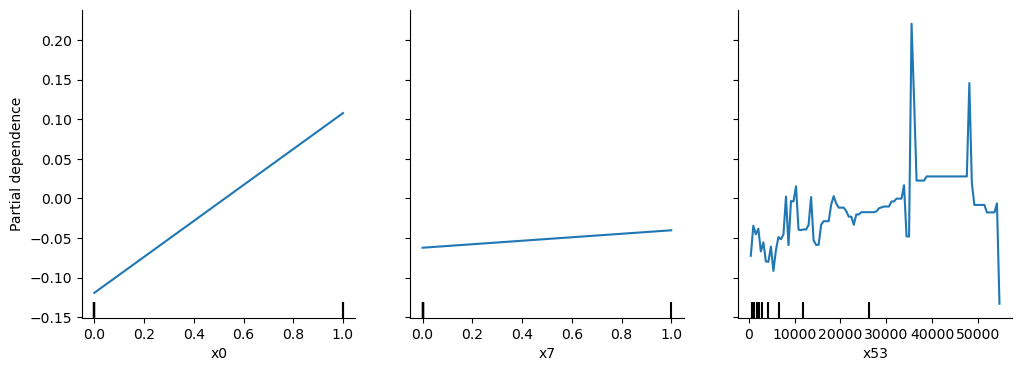

In [115]:
from sklearn.inspection import partial_dependence  # to access the value rather than plotting
from sklearn.inspection import PartialDependenceDisplay

clf = class_models['gradient_boosting']['fitted']

pdp_display = PartialDependenceDisplay.from_estimator(clf, x_train_trf.toarray(), feature_idx)

fig = pdp_display.figure_

fig.set_size_inches(12, 4)  
sns.despine()

Or by this way to create the xlabel...

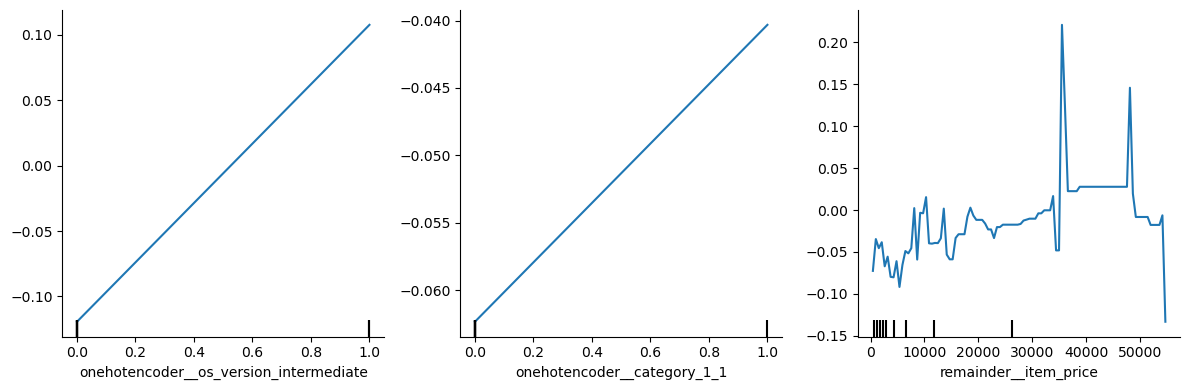

In [146]:
# beware of this figure as they're not sharing the same y anymore
# this code provided below only to show the way to change the xlabel is to set it explicitly using for loop subplots

num_features = len(feature_idx)
clf = class_models['gradient_boosting']['fitted']

fig, axes = plt.subplots(1, num_features, figsize=(12, 4),sharey=True)

for i, idx, name in zip(range(0, num_features), feature_idx, feature_names):
    pdp_display = PartialDependenceDisplay.from_estimator(clf, x_train_trf.toarray(), [idx], ax=axes[i])
    plt.xlabel(name)
    plt.ylabel('')

fig.tight_layout()
sns.despine()

Based on the documentation, we can **investigate the interaction** as well like the one below...

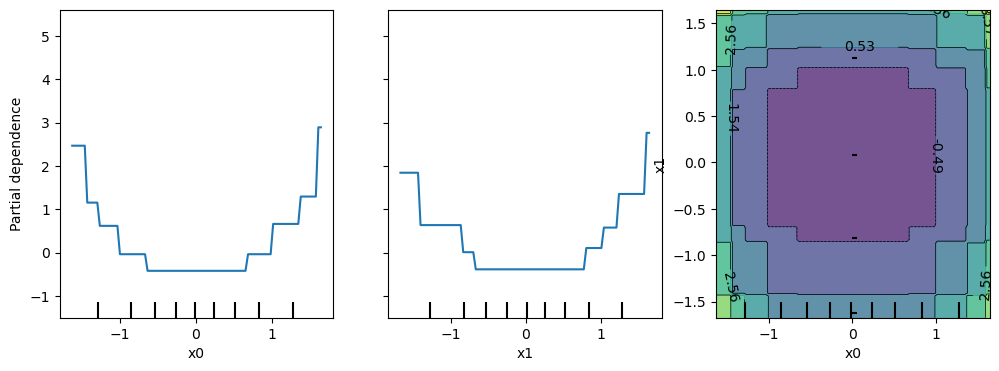

In [147]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

X, y = make_hastie_10_2(random_state=0)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X, y)

# the interaction is stated here,
# by creating a tuple of the index that we want to see the interaction
features = [0, 1, (0, 1)]

PartialDependenceDisplay.from_estimator(clf, X, features).figure_.set_size_inches(12,4)

    Disadvantage of PDP
    
- Simplified Representation: It can only display up to two features at a time
- Assumption of Independence: PDPs assume independence between features, which may not be accurate in real-world scenarios

### Individual Conditional Expectation (ICE)

ICE comes for an alternative if PDP obsecure the variance in the data as PDP averages out everything and we might lose a lot of data. 

The way it works:

1. **Select a specific instance** from your dataset for which you want to analyze the relationship between a feature and the predicted outcome.

2. **Choose the feature of interest** that you want to investigate (e.g., square footage).

3. **Vary the value of the chosen feature for the selected instance** while keeping all other features fixed.

4. **Make predictions using your machine learning model** for each different value of the chosen feature. Record the predicted outcome (e.g., housing price) for each variation.

5. **Repeat steps 3 and 4 for multiple instances** in your dataset, selecting a new instance each time. This will help capture the variation in the relationship between the feature and predicted outcome across different instances.

6. For each instance, **plot the recorded predicted outcomes on a graph**. The x-axis represents the different values of the feature, and the y-axis represents the predicted outcomes.

7. **Each line on the plot represents the predicted outcome** trajectory for a specific instance as the feature value changes. The lines may have different shapes and slopes, indicating how the predicted outcome changes for each instance as the feature varies.

8. Optionally, you can overlay the individual lines with an average line that represents the average predicted outcome across all instances for each feature value. This can provide additional context and help identify trends.

9. Analyze the ICE plot to gain insights into the individual-level relationship between the feature and predicted outcome. Observe the variation in predicted outcomes for different instances as the feature value changes. Pay attention to differences in line shapes, slopes, and intersections to understand how the feature impacts the predicted outcome at the individual level

    Select specific instance from the dataset

In [163]:
sample_size = 0.01
sample_idx = np.random.choice(df_main.shape[0],
                              math.ceil(df_main.shape[0] * sample_size),
                              replace=False)

print("number of instances we're going to investigate:", len(sample_idx))

number of instances we're going to investigate: 793


    Choosing the feature of interest

In [154]:
feature_names = ['onehotencoder__os_version_intermediate', 'onehotencoder__category_1_1', 'remainder__item_price']
feature_idx = [list(x_cols).index(x) for x in feature_names]

feature_idx

[0, 7, 53]

    Steps 3-7 is done by scikit-learn module, by employing PartialDependenceDisplay.from_estimator() method

In [ ]:
clf = class_models['gradient_boosting']['fitted']

pdp_display = PartialDependenceDisplay.from_estimator(clf, 
                                                      x_train_trf.toarray()[sample_idx], 
                                                      feature_idx, 
                                                      kind='both')  # set kind to 'individual' to remove average line
fig = pdp_display.figure_

fig.set_size_inches(20, 4)
sns.despine()

There's another variation called **Centered ICE (cICE)** where it centers the ICE at the first value on the x-axis...

This is to take account of:

- There are too many lines in an ICE plot, 
- It can be difficult to see differences between individual samples and interpret the model.

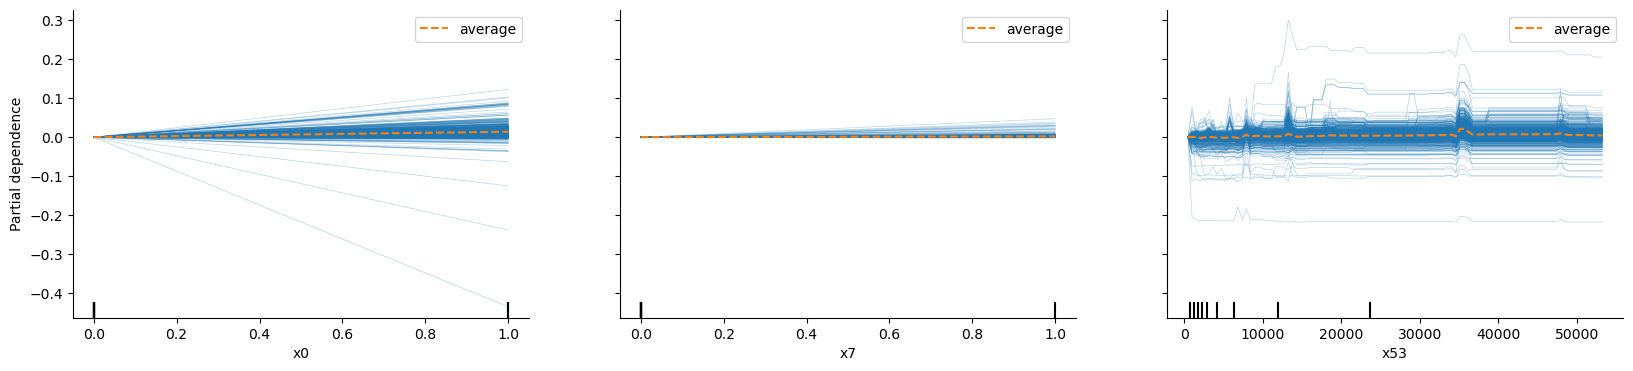

In [173]:
clf = class_models['gradient_boosting']['fitted']

pdp_display = PartialDependenceDisplay.from_estimator(clf, 
                                                      x_train_trf.toarray()[sample_idx], 
                                                      feature_idx, 
                                                      kind='both',
                                                      centered=True)  # set centered to true to make cICE
fig = pdp_display.figure_

fig.set_size_inches(20, 4)
sns.despine()

    Disadvantage of ICE

- ICE is inherited from PDP, so the problem PDP has, ICE will also share: assumption of independece of the features
- ICE cannot see the interaction features with two continuous or high-cardinality features (like ID, column with a lot of unique data)